In [3]:
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
#from sensitivity_plot import sensitivity_plot
import statsmodels.api as sm
import numbers
from sklearn.metrics import mean_squared_error
import math
from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.neural_network import MLPRegressor
import pylab 
import scipy.stats as stats
from whitebox.eval import WhiteBoxSensitivity
from sklearn.model_selection import cross_val_score
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence

C:\Users\jlewris\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


ModuleNotFoundError: No module named 'whitebox'

In [ ]:
df = pd.read_csv('./datasets/final_data.csv', low_memory=False)
#final_data = final_data.drop('LanguageRecommendationSelect', axis=1)

In [ ]:
#for details on data cleaning see'Data_Cleaning.ipynb'
#raw data has 5617 rows
df.shape

(5617, 282)

In [4]:
#get rid of all NAs
#final_data = final_data.dropna()
df = df.reset_index(drop=True)
df.shape

(5617, 282)

In [2]:
dependentVar = 'JobSatisfaction'

In [6]:
spike_cols = [col for col in df.columns if 'WorkToolsSelect' in col]
df = df.drop(spike_cols, axis=1)
spike_cols = [col for col in df.columns if 'WorkHardwareSelect' in col]
df = df.drop(spike_cols, axis=1)

#drop country specific axis as it's hard to interpret and clouds the impact of other variables
df= df.drop('Average Salary Within Country', axis=1)

In [7]:
#drop people who don't consider themselves Data Scientists

df = df[df['DataScienceIdentitySelect'] !='No']
df.shape

(4364, 221)

In [8]:
df[dependentVar].describe()

count    4364.000000
mean        6.880614
std         2.108277
min         1.000000
25%         6.000000
50%         7.000000
75%         8.000000
max        10.000000
Name: JobSatisfaction, dtype: float64

In [9]:
#drop columns with WorkToolsSelect_C as they are sparse and not important here and have a ++ that is problematic
df['JobSatisfaction'].quantile([.1,.2,.3,.4,.5,.6,.7,.8,.9])

0.1    4.0
0.2    5.0
0.3    6.0
0.4    7.0
0.5    7.0
0.6    8.0
0.7    8.0
0.8    9.0
0.9    9.0
Name: JobSatisfaction, dtype: float64

In [10]:

#convert string variables to categorical variables 
df[df.select_dtypes(['object']).columns] = df.select_dtypes(['object']).apply(lambda x: x.astype('category'))

# select only those columns which are categorical in nature and make a copy for modeling
df.select_dtypes(include = ['category'])
model_df = df.copy(deep = True)

# create dummies example using all categorical columns
# this naming convention must be precise for WhiteBox to recognize what dummies are associated with what variables
dummies = pd.concat([pd.get_dummies(model_df.loc[:, col], prefix = col) for col in model_df.select_dtypes(include = ['category']).columns], axis = 1)

# add the dummies to the numeric dataframe for modeling
finaldf = pd.concat([model_df.select_dtypes(include = [np.number]), dummies], axis = 1)


In [11]:
#make train and test samles
X_train, X_test, y_train, y_test = train_test_split(finaldf.loc[:, finaldf.columns != dependentVar], df.loc[:, dependentVar], test_size=0.1, random_state=42)

In [12]:
#make a Random Forest object trained to predict Job Satisfaction 
Rf = RandomForestRegressor(n_estimators=50, min_weight_fraction_leaf = .01,  oob_score=True)
#Rf.fit(xTrain,final_data['JobSatisfaction'])
Rf.fit(finaldf.loc[:, finaldf.columns != dependentVar],df.loc[:, dependentVar])



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.01, n_estimators=50, n_jobs=1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [13]:
scores = cross_val_score(Rf, finaldf.loc[:, finaldf.columns != dependentVar], df.loc[:, dependentVar], cv=5)
print(scores)
print(scores.mean())

[0.18308501 0.18759537 0.15615772 0.16587701 0.14228466]
0.1669999536512514


In [14]:
est = GradientBoostingRegressor(n_estimators=200, learning_rate=.05,  min_weight_fraction_leaf = .01, loss='ls', random_state = 25)
est.fit(finaldf.loc[:, finaldf.columns != dependentVar], df.loc[:, dependentVar])

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.01,
             n_estimators=200, presort='auto', random_state=25,
             subsample=1.0, verbose=0, warm_start=False)

In [15]:
scores = cross_val_score(est, finaldf.loc[:, finaldf.columns != dependentVar], df.loc[:, dependentVar], cv=5)
print(scores)
print(scores.mean())

[0.18925893 0.18992717 0.21035423 0.21166745 0.1718822 ]
0.19461799567867427


In [16]:
#fit lasso model
lass = linear_model.Lasso(alpha=0.03)
lass.fit(finaldf.loc[:, finaldf.columns != dependentVar],df.loc[:, dependentVar])

Lasso(alpha=0.03, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [17]:
scores = cross_val_score(lass, finaldf.loc[:, finaldf.columns != dependentVar], df.loc[:, dependentVar], cv=5)
print(scores)
print(scores.mean())

[0.1785534  0.19955505 0.20235981 0.20088654 0.16309163]
0.1888892864639396


In [18]:
#generate coefficients and then print them
coef_dict = {}
for coef, feat in zip(lass.coef_,X_train.columns):
    if coef != 0:
        coef_dict[feat] = round(coef,3)

In [19]:
pd.DataFrame(list(coef_dict.items()), columns=['Varialbe', 'Coefficient']).sort_values(['Coefficient'])

,Varialbe,Coefficient
30,WorkChallengeFrequencyPolitics_Most of the time,-0.620
43,Continent_Asia,-0.458
20,TitleFit_Poorly,-0.396
42,SalaryChange_Has stayed about the same (has no...,-0.286
40,RemoteWork_Never,-0.216
34,WorkChallengeFrequencyTalent_Most of the time,-0.174
46,CurrentEmployerType_Employed by a company that...,-0.142
37,WorkChallengeFrequencyDataAccess_Never,-0.079
33,WorkChallengeFrequencyDirtyData_Never,-0.072
25,JobFunctionSelect_Analyze and understand data ...,-0.066


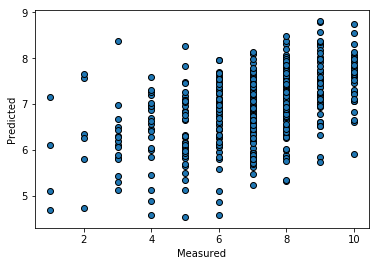

In [20]:
#test validity of assumptions of the regression's coefficients 
y = y_test
predicted = lass.predict(X_test)
fig, ax = plt.subplots()
ax.scatter(y, predicted, edgecolors=(0, 0, 0))
#ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=6)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

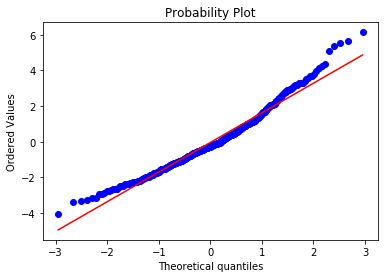

In [21]:
y = y_test
predicted = lass.predict(X_test)
error2 = (predicted-y_test)
stats.probplot(error2, dist="norm", plot=pylab)
pylab.show()

Age


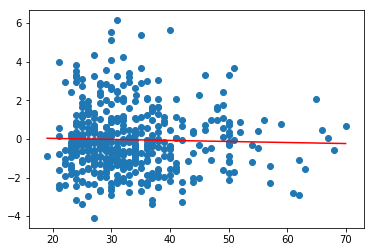

LearningCategorySelftTaught


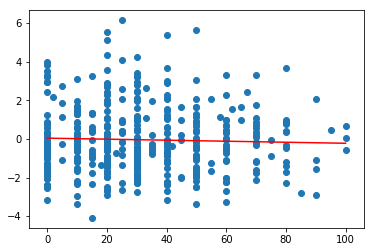

LearningCategoryOnlineCourses


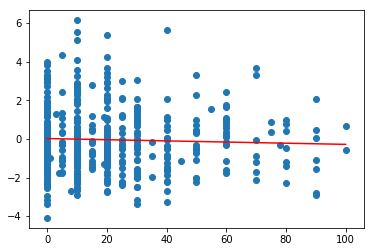

LearningCategoryWork


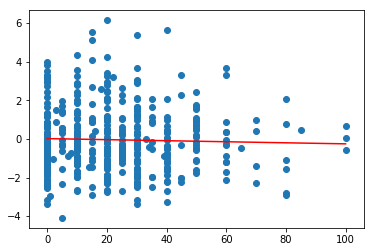

LearningCategoryUniversity


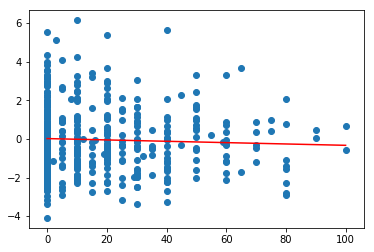

LearningCategoryKaggle


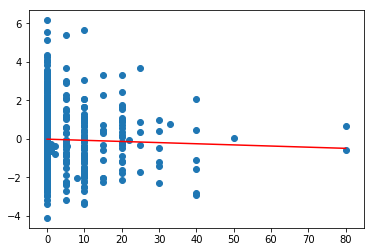

TimeGatheringData


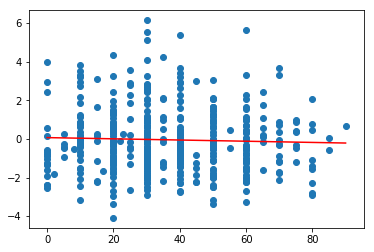

TimeModelBuilding


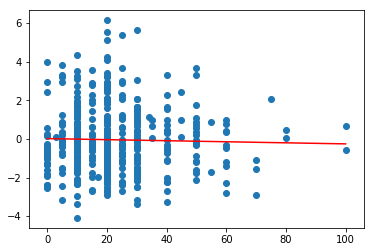

TimeProduction


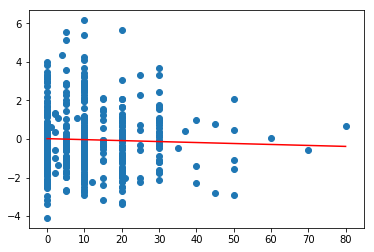

TimeVisualizing


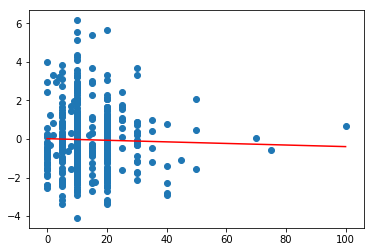

TimeFindingInsights


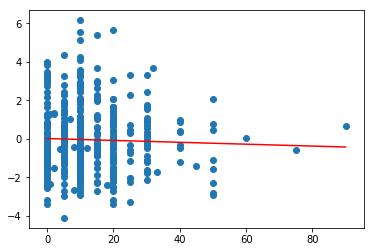

TimeOtherSelect


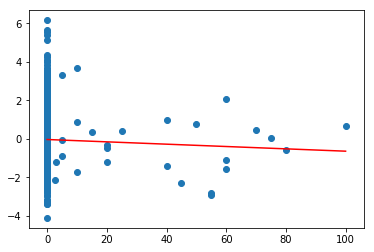

Unnamed: 0


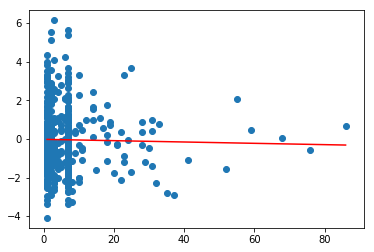

Percent Above/Below Average Salary


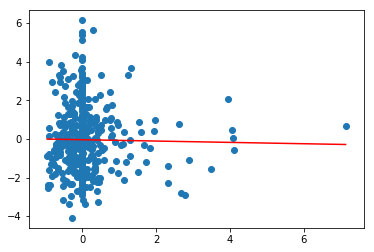

NumberChallenges


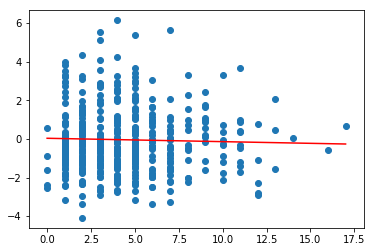

NumberPlatforms


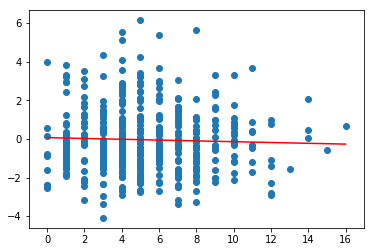

Hardware Types Used


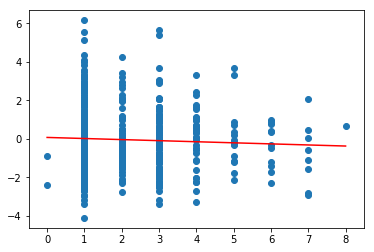

Number of Algorithims


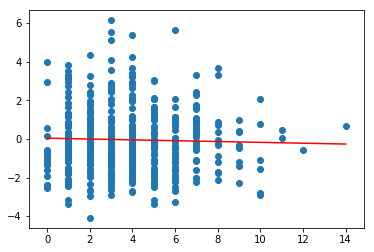

CurrentJobTitleSelect_Data Scientist


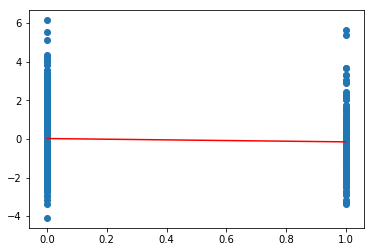

TitleFit_Perfectly


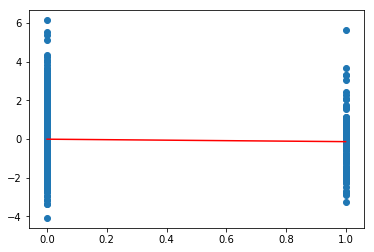

TitleFit_Poorly


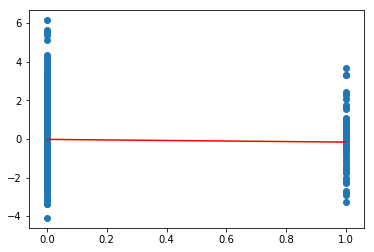

DataScienceIdentitySelect_Sort of (Explain more)


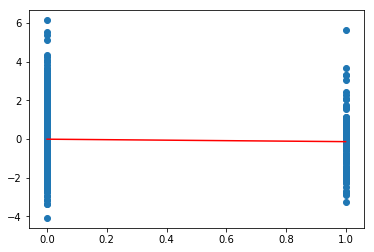

EmployerSizeChange_Increased significantly


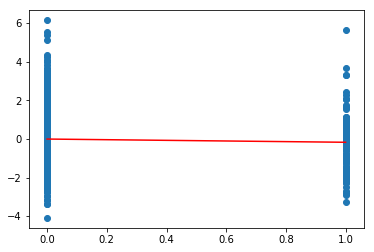

EmployerSizeChange_Increased slightly


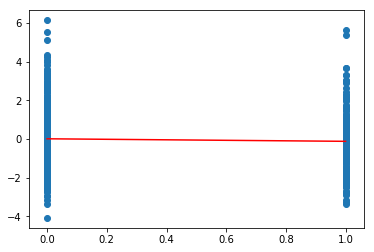

UniversityImportance_Very important


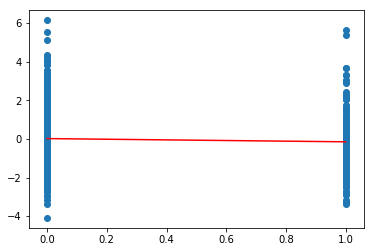

JobFunctionSelect_Analyze and understand data to influence product or business decisions


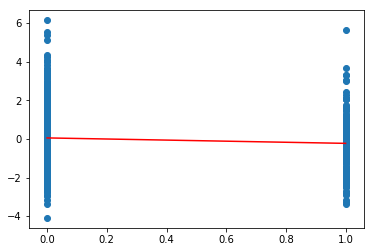

WorkToolsFrequencyJupyter_Most of the time


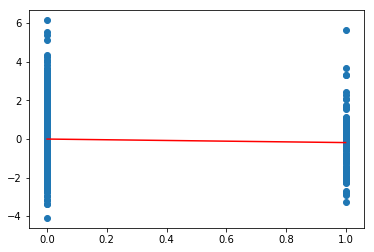

WorkToolsFrequencyJupyter_Never


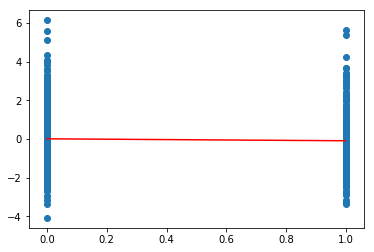

WorkMethodsFrequencyDataVisualization_Most of the time


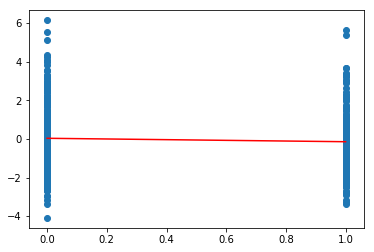

WorkMethodsFrequencyTextAnalysis_Never


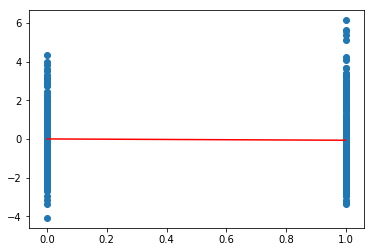

WorkChallengeFrequencyPolitics_Most of the time


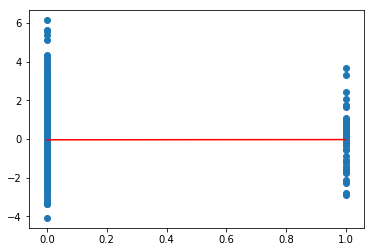

WorkChallengeFrequencyPolitics_Never


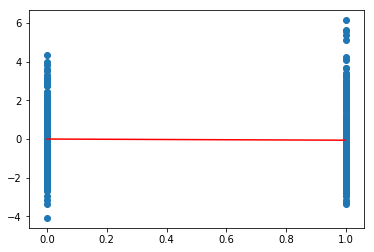

WorkChallengeFrequencyUnusedResults_Never


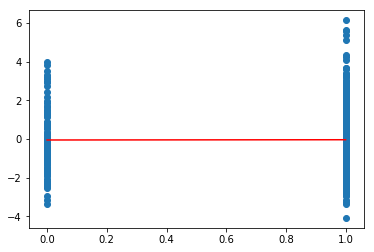

WorkChallengeFrequencyDirtyData_Never


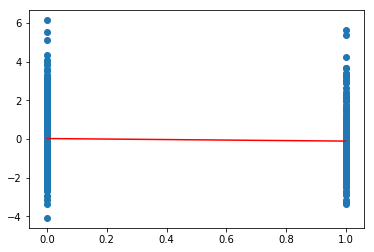

WorkChallengeFrequencyTalent_Most of the time


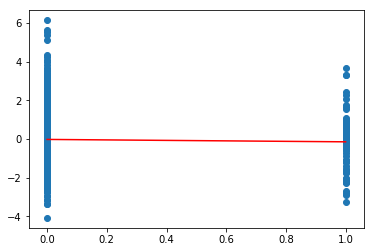

WorkChallengeFrequencyTalent_Never


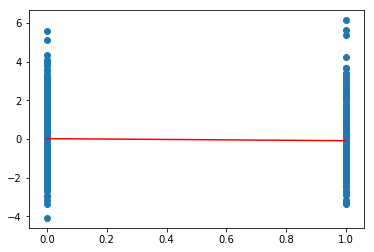

WorkChallengeFrequencyPrivacy_Never


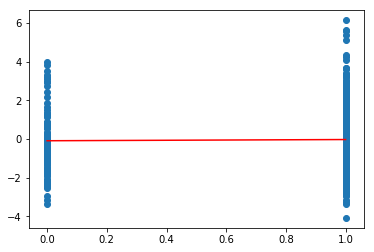

WorkChallengeFrequencyDataAccess_Never


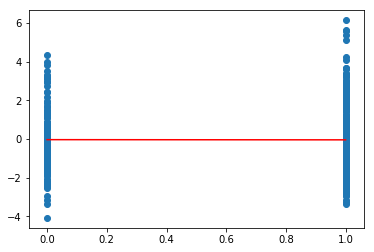

WorkDataVisualizations_10-25% of projects


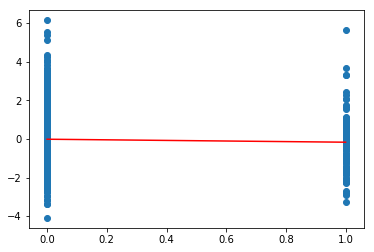

WorkDataVisualizations_Less than 10% of projects


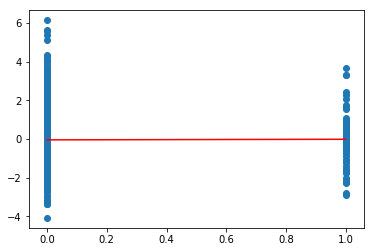

RemoteWork_Never


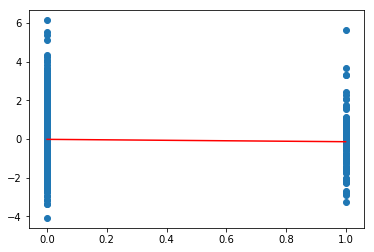

SalaryChange_Has increased 20% or more


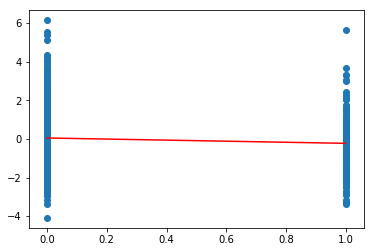

SalaryChange_Has stayed about the same (has not increased or decreased more than 5%)


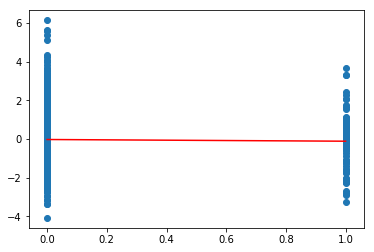

Continent_Asia


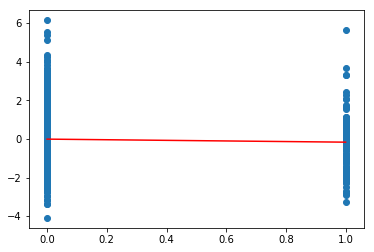

Continent_Other


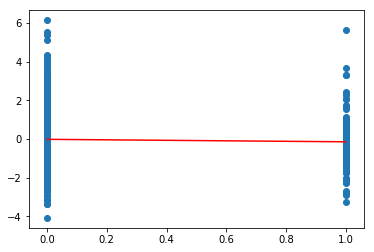

CurrentEmployerType_Employed by a company that doesn't perform advanced analytics_No


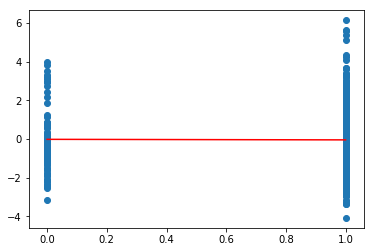

CurrentEmployerType_Employed by a company that performs advanced analytics_No


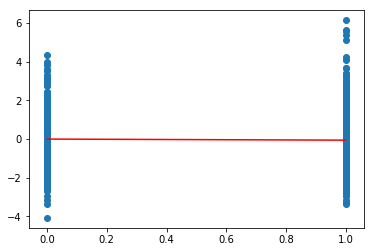

CurrentEmployerType_Employed by a company that performs advanced analytics_Yes


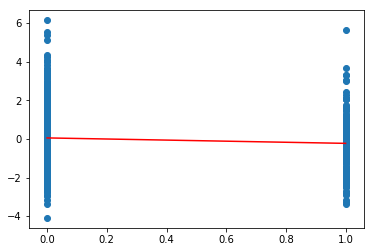

In [22]:
j=221


for i in range(0,len(coef_dict)):
    fig, ax = plt.subplots()
    temp = X_test[list(coef_dict)[i]]
    x = temp.sort_values()
    #print(len(temp.sort_values))
    y=error2
    fit = np.polyfit(x, y, deg=1)
    ax.plot(x, fit[0] * x + fit[1], color='red')
    ax.scatter(x, y)
    print(list(coef_dict)[i])
    plt.show()


In [23]:
feature_importance = est.feature_importances_
feature_length = feature_importance.shape[0]
feature_10 = feature_length-20
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)



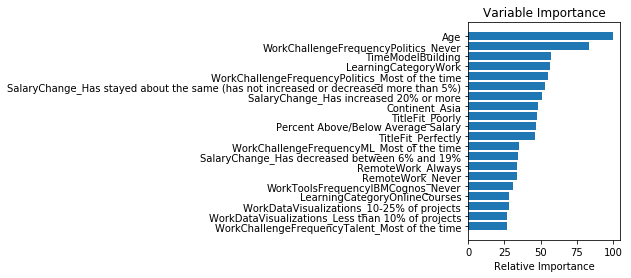

In [24]:
# Plot top 10 features based on importance
feature_importance = est.feature_importances_
feature_length = feature_importance.shape[0]
feature_10 = feature_length-20
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
#sorted_idx=sorted_idx[0:10]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos[feature_10:feature_length], feature_importance[sorted_idx][feature_10:feature_length], align='center')
plt.yticks(pos[feature_10:feature_length], np.array(list(X_train))[sorted_idx][feature_10:feature_length])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [25]:
df.groupby(['WorkChallengeFrequencyPolitics'])['JobSatisfaction'].describe()

,count,mean,std,min,25%,50%,75%,max
WorkChallengeFrequencyPolitics,,,,,,,,
Most of the time,462.0,5.402597,2.447327,1.0,4.0,6.0,7.0,10.0
Never,2628.0,7.298706,1.938384,1.0,6.0,8.0,9.0,10.0
Often,691.0,6.415340,2.040814,1.0,5.0,7.0,8.0,10.0
Rarely,59.0,6.830508,2.190517,1.0,5.0,7.0,8.0,10.0
Sometimes,524.0,6.706107,1.943140,1.0,6.0,7.0,8.0,10.0


In [26]:
df.groupby(['WorkChallengeFrequencyPolitics'])['WorkChallengeFrequencyPolitics'].count()/df['WorkChallengeFrequencyPolitics'].count()

WorkChallengeFrequencyPolitics
Most of the time    0.105866
Never               0.602200
Often               0.158341
Rarely              0.013520
Sometimes           0.120073
Name: WorkChallengeFrequencyPolitics, dtype: float64

In [27]:
df['Entire_Population'] = 'Entire Population'
df['Entire_Population'] = pd.Categorical(df['Entire_Population'])

In [28]:
spike_cols = [col for col in df.columns if 'Population' in col]
spike_cols

['Entire_Population']

In [29]:
#'Average Salary Within Country' : 'Average Salary Within Country',  
featuredict = { 'WorkChallengeFrequencyPolitics' : 'Frequency of Political Work Issues', 
               'WorkDataVisualizations' : 'Percent of Work Making Visuals',
               'MLToolNextYearSelect' : 'Machine Learning Tool I Plan to Learn Next',
                             'TimeModelBuilding' : 'Time Spent Model Building',
                             'Number of Algorithims' : 'Number of Algorithms',
                             'SalaryChange' : 'Salary Change',
                             'EmployerSizeChange' : 'YoY Change in Employer Size',
                             'Percent Above/Below Average Salary' : 'Percent Above/Below Average Salary',              
                             'LearningCategoryWork' : 'Proportion of Knowledge Gained From Work',
                             'LearningCategoryOnlineCourses': 'Proportion of Knowledge Gained Online',
                             'LearningPlatformUsefulnessCompany' : 'Usefulness of Firm Learning Platform',
                             'WorkChallengeFrequencyDomainExpertise' : 'Frequency of Personally Lacking Domain Expertise',
                             'WorkChallengeFrequencyTalent' : 'Challenge in finding talent',
               'WorkChallengeFrequencyML' : 'Work Challenge - Machine Learning',
                             'RemoteWork' : 'Remote Work',
                             'Age' : 'Age',
                             'TitleFit' : 'Title Fit',
                                     'DataScienceIdentitySelect' : 'Data Scientist Identity',
             
                             'Continent' : 'Continent',
                             'SalaryChange' : 'YoY Salary Change',
                             'JobSatisfaction' : 'Job Satisfaction',
                             'AlgorithmUnderstandingLevel' : 'Algorithm Understanding Level',
                              'UniversityImportance' : 'Importance of Attending a University',
               'Entire_Population' : 'Entire Population'
                         }

In [30]:
WB=None

WB = WhiteBoxSensitivity(est,
                    model_df=finaldf,
                    ydepend=dependentVar,
                    cat_df=df,
                    groupbyvars=['Continent','DataScienceIdentitySelect','WorkChallengeFrequencyPolitics', 'AlgorithmUnderstandingLevel', 'TitleFit', 'Entire_Population'],
                    aggregate_func=np.mean,
                          featuredict  = featuredict,
                    verbose=None,
                     std_num=1, 
                          
                    )


In [31]:
%%time 
WB.run()


[{'Type': 'Categorical', 'Change': 'Never', 'Data': [{'groupByValue': 'Asia', 'Frequency of Political Work Issues': 'Most of the time', 'predictedYSmooth': 1.2386768725646695, 'groupByVarName': 'Continent'}, {'groupByValue': 'Asia', 'Frequency of Political Work Issues': 'Often', 'predictedYSmooth': 0.5580187891622298, 'groupByVarName': 'Continent'}, {'groupByValue': 'Asia', 'Frequency of Political Work Issues': 'Rarely', 'predictedYSmooth': 0.502633418882385, 'groupByVarName': 'Continent'}, {'groupByValue': 'Asia', 'Frequency of Political Work Issues': 'Sometimes', 'predictedYSmooth': 0.49080002970424014, 'groupByVarName': 'Continent'}, {'groupByValue': 'Europe', 'Frequency of Political Work Issues': 'Most of the time', 'predictedYSmooth': 1.3268457829742506, 'groupByVarName': 'Continent'}, {'groupByValue': 'Europe', 'Frequency of Political Work Issues': 'Often', 'predictedYSmooth': 0.6000614354982517, 'groupByVarName': 'Continent'}, {'groupByValue': 'Europe', 'Frequency of Political W

[{'Type': 'Categorical', 'Change': '76-99% of projects', 'Data': [{'groupByValue': 'Asia', 'Percent of Work Making Visuals': '10-25% of projects', 'predictedYSmooth': 0.11953606193895003, 'groupByVarName': 'Continent'}, {'groupByValue': 'Asia', 'Percent of Work Making Visuals': '100% of projects', 'predictedYSmooth': 0.0, 'groupByVarName': 'Continent'}, {'groupByValue': 'Asia', 'Percent of Work Making Visuals': '26-50% of projects', 'predictedYSmooth': 0.0, 'groupByVarName': 'Continent'}, {'groupByValue': 'Asia', 'Percent of Work Making Visuals': '51-75% of projects', 'predictedYSmooth': -0.011404311420843648, 'groupByVarName': 'Continent'}, {'groupByValue': 'Asia', 'Percent of Work Making Visuals': 'Less than 10% of projects', 'predictedYSmooth': 0.13902982978097753, 'groupByVarName': 'Continent'}, {'groupByValue': 'Asia', 'Percent of Work Making Visuals': 'None', 'predictedYSmooth': 0.0, 'groupByVarName': 'Continent'}, {'groupByValue': 'Europe', 'Percent of Work Making Visuals': '10-

[{'Type': 'Categorical', 'Change': 'TensorFlow', 'Data': [{'groupByValue': 'Asia', 'Machine Learning Tool I Plan to Learn Next': 'Amazon Machine Learning', 'predictedYSmooth': 0.0, 'groupByVarName': 'Continent'}, {'groupByValue': 'Asia', 'Machine Learning Tool I Plan to Learn Next': 'Amazon Web services', 'predictedYSmooth': 0.0, 'groupByVarName': 'Continent'}, {'groupByValue': 'Asia', 'Machine Learning Tool I Plan to Learn Next': 'Angoss', 'predictedYSmooth': 0.0, 'groupByVarName': 'Continent'}, {'groupByValue': 'Asia', 'Machine Learning Tool I Plan to Learn Next': 'C/C++', 'predictedYSmooth': 0.0, 'groupByVarName': 'Continent'}, {'groupByValue': 'Asia', 'Machine Learning Tool I Plan to Learn Next': 'Cloudera', 'predictedYSmooth': 0.0, 'groupByVarName': 'Continent'}, {'groupByValue': 'Asia', 'Machine Learning Tool I Plan to Learn Next': 'DataRobot', 'predictedYSmooth': 0.0, 'groupByVarName': 'Continent'}, {'groupByValue': 'Asia', 'Machine Learning Tool I Plan to Learn Next': 'Flume', 

                                using raw data as opposed to percentile groups.
                                
Group size: (59, 5)


[{'Type': 'Continuous', 'Change': '15.02', 'Data': [{'groupByValue': 'Asia', 'Time Spent Model Building': 0.0, 'predictedYSmooth': 0.13301385019713355, 'groupByVarName': 'Continent'}, {'groupByValue': 'Asia', 'Time Spent Model Building': 3.0, 'predictedYSmooth': 0.08010733758266486, 'groupByVarName': 'Continent'}, {'groupByValue': 'Asia', 'Time Spent Model Building': 5.0, 'predictedYSmooth': 0.013453939144596635, 'groupByVarName': 'Continent'}, {'groupByValue': 'Asia', 'Time Spent Model Building': 10.0, 'predictedYSmooth': 0.010453922931139843, 'groupByVarName': 'Continent'}, {'groupByValue': 'Asia', 'Time Spent Model Building': 15.0, 'predictedYSmooth': 0.012188583459985275, 'groupByVarName': 'Continent'}, {'groupByValue': 'Asia', 'Time Spent Model Building': 20.0, 'predictedYSmooth': -0.00013344859423209887, 'groupByVarName': 'Continent'}, {'groupByValue': 'Asia', 'Time Spent Model Building': 25.0, 'predictedYSmooth': 0.0, 'groupByVarName': 'Continent'}, {'groupByValue': 'Asia', 'Tim

                                using raw data as opposed to percentile groups.
                                
Group size: (59, 5)


[{'Type': 'Continuous', 'Change': '2.39', 'Data': [{'groupByValue': 'Asia', 'Number of Algorithms': 0.0, 'predictedYSmooth': 0.04925469359505687, 'groupByVarName': 'Continent'}, {'groupByValue': 'Asia', 'Number of Algorithms': 1.0, 'predictedYSmooth': 0.0902660205486937, 'groupByVarName': 'Continent'}, {'groupByValue': 'Asia', 'Number of Algorithms': 2.0, 'predictedYSmooth': 0.048075371934418326, 'groupByVarName': 'Continent'}, {'groupByValue': 'Asia', 'Number of Algorithms': 3.0, 'predictedYSmooth': 0.014020013578572054, 'groupByVarName': 'Continent'}, {'groupByValue': 'Asia', 'Number of Algorithms': 4.0, 'predictedYSmooth': 0.004411779465362844, 'groupByVarName': 'Continent'}, {'groupByValue': 'Asia', 'Number of Algorithms': 5.0, 'predictedYSmooth': 0.0, 'groupByVarName': 'Continent'}, {'groupByValue': 'Asia', 'Number of Algorithms': 6.0, 'predictedYSmooth': 0.0, 'groupByVarName': 'Continent'}, {'groupByValue': 'Asia', 'Number of Algorithms': 7.0, 'predictedYSmooth': 0.0, 'groupByVar

[{'Type': 'Categorical', 'Change': 'Has increased 20% or more', 'Data': [{'groupByValue': 'Asia', 'YoY Salary Change': 'Has decreased 20% or more', 'predictedYSmooth': 0.24338210641529923, 'groupByVarName': 'Continent'}, {'groupByValue': 'Asia', 'YoY Salary Change': 'Has decreased between 6% and 19%', 'predictedYSmooth': 0.8272320276913175, 'groupByVarName': 'Continent'}, {'groupByValue': 'Asia', 'YoY Salary Change': 'Has increased between 6% and 19%', 'predictedYSmooth': 0.24785322569794901, 'groupByVarName': 'Continent'}, {'groupByValue': 'Asia', 'YoY Salary Change': 'Has stayed about the same (has not increased or decreased more than 5%)', 'predictedYSmooth': 0.45769146355826446, 'groupByVarName': 'Continent'}, {'groupByValue': 'Asia', 'YoY Salary Change': 'I was not employed 3 years ago', 'predictedYSmooth': 0.2562636395707879, 'groupByVarName': 'Continent'}, {'groupByValue': 'Asia', 'YoY Salary Change': 'Other', 'predictedYSmooth': 0.25620278547448416, 'groupByVarName': 'Continent

[{'Type': 'Categorical', 'Change': 'Increased slightly', 'Data': [{'groupByValue': 'Asia', 'YoY Change in Employer Size': 'Decreased significantly', 'predictedYSmooth': 0.0791565709253846, 'groupByVarName': 'Continent'}, {'groupByValue': 'Asia', 'YoY Change in Employer Size': 'Decreased slightly', 'predictedYSmooth': 0.17193586272540648, 'groupByVarName': 'Continent'}, {'groupByValue': 'Asia', 'YoY Change in Employer Size': 'Increased significantly', 'predictedYSmooth': -0.037799855148432815, 'groupByVarName': 'Continent'}, {'groupByValue': 'Asia', 'YoY Change in Employer Size': 'Stayed the same', 'predictedYSmooth': 0.012396602198165418, 'groupByVarName': 'Continent'}, {'groupByValue': 'Europe', 'YoY Change in Employer Size': 'Decreased significantly', 'predictedYSmooth': 0.07055369562376558, 'groupByVarName': 'Continent'}, {'groupByValue': 'Europe', 'YoY Change in Employer Size': 'Decreased slightly', 'predictedYSmooth': 0.25572485904473763, 'groupByVarName': 'Continent'}, {'groupByV

                                using raw data as opposed to percentile groups.
                                
Group size: (59, 5)


[{'Type': 'Continuous', 'Change': '0.59', 'Data': [{'groupByValue': 'Asia', 'Percent Above/Below Average Salary': -0.9469742618156772, 'predictedYSmooth': -0.1538785385751857, 'groupByVarName': 'Continent'}, {'groupByValue': 'Asia', 'Percent Above/Below Average Salary': -0.929299015754236, 'predictedYSmooth': -0.0418453138572093, 'groupByVarName': 'Continent'}, {'groupByValue': 'Asia', 'Percent Above/Below Average Salary': -0.9270322389994168, 'predictedYSmooth': 0.0, 'groupByVarName': 'Continent'}, {'groupByValue': 'Asia', 'Percent Above/Below Average Salary': -0.9151588189050832, 'predictedYSmooth': 0.0, 'groupByVarName': 'Continent'}, {'groupByValue': 'Asia', 'Percent Above/Below Average Salary': -0.9007656507304174, 'predictedYSmooth': 0.0, 'groupByVarName': 'Continent'}, {'groupByValue': 'Asia', 'Percent Above/Below Average Salary': -0.8585980315084721, 'predictedYSmooth': 0.0, 'groupByVarName': 'Continent'}, {'groupByValue': 'Asia', 'Percent Above/Below Average Salary': -0.816841

                                using raw data as opposed to percentile groups.
                                
Group size: (59, 5)


[{'Type': 'Continuous', 'Change': '19.64', 'Data': [{'groupByValue': 'Asia', 'Proportion of Knowledge Gained From Work': 0.0, 'predictedYSmooth': 0.07542557398733454, 'groupByVarName': 'Continent'}, {'groupByValue': 'Asia', 'Proportion of Knowledge Gained From Work': 5.0, 'predictedYSmooth': 0.11098984002460238, 'groupByVarName': 'Continent'}, {'groupByValue': 'Asia', 'Proportion of Knowledge Gained From Work': 10.0, 'predictedYSmooth': 0.09609379249062303, 'groupByVarName': 'Continent'}, {'groupByValue': 'Asia', 'Proportion of Knowledge Gained From Work': 15.0, 'predictedYSmooth': 0.09560144253646632, 'groupByVarName': 'Continent'}, {'groupByValue': 'Asia', 'Proportion of Knowledge Gained From Work': 20.0, 'predictedYSmooth': 0.06843611754326333, 'groupByVarName': 'Continent'}, {'groupByValue': 'Asia', 'Proportion of Knowledge Gained From Work': 25.0, 'predictedYSmooth': 0.03403827993274767, 'groupByVarName': 'Continent'}, {'groupByValue': 'Asia', 'Proportion of Knowledge Gained From 

                                using raw data as opposed to percentile groups.
                                
Group size: (59, 5)


[{'Type': 'Continuous', 'Change': '21.4', 'Data': [{'groupByValue': 'Asia', 'Proportion of Knowledge Gained Online': 0.0, 'predictedYSmooth': -0.018210954415156303, 'groupByVarName': 'Continent'}, {'groupByValue': 'Asia', 'Proportion of Knowledge Gained Online': 5.0, 'predictedYSmooth': -0.014013408802492288, 'groupByVarName': 'Continent'}, {'groupByValue': 'Asia', 'Proportion of Knowledge Gained Online': 10.0, 'predictedYSmooth': -0.02745297740042716, 'groupByVarName': 'Continent'}, {'groupByValue': 'Asia', 'Proportion of Knowledge Gained Online': 15.0, 'predictedYSmooth': -0.013300096924029283, 'groupByVarName': 'Continent'}, {'groupByValue': 'Asia', 'Proportion of Knowledge Gained Online': 20.0, 'predictedYSmooth': -0.015151635604651312, 'groupByVarName': 'Continent'}, {'groupByValue': 'Asia', 'Proportion of Knowledge Gained Online': 25.0, 'predictedYSmooth': -0.048785070457110745, 'groupByVarName': 'Continent'}, {'groupByValue': 'Asia', 'Proportion of Knowledge Gained Online': 30.0

[{'Type': 'Categorical', 'Change': 'Somewhat useful', 'Data': [{'groupByValue': 'Asia', 'Usefulness of Firm Learning Platform': 'Not Useful', 'predictedYSmooth': 0.0, 'groupByVarName': 'Continent'}, {'groupByValue': 'Asia', 'Usefulness of Firm Learning Platform': 'Very useful', 'predictedYSmooth': -0.23403542913216183, 'groupByVarName': 'Continent'}, {'groupByValue': 'Europe', 'Usefulness of Firm Learning Platform': 'Not Useful', 'predictedYSmooth': 0.0, 'groupByVarName': 'Continent'}, {'groupByValue': 'Europe', 'Usefulness of Firm Learning Platform': 'Very useful', 'predictedYSmooth': -0.24917179885998164, 'groupByVarName': 'Continent'}, {'groupByValue': 'North America', 'Usefulness of Firm Learning Platform': 'Not Useful', 'predictedYSmooth': 0.0, 'groupByVarName': 'Continent'}, {'groupByValue': 'North America', 'Usefulness of Firm Learning Platform': 'Very useful', 'predictedYSmooth': -0.22731315501184576, 'groupByVarName': 'Continent'}, {'groupByValue': 'Other', 'Usefulness of Firm

[{'Type': 'Categorical', 'Change': 'Never', 'Data': [{'groupByValue': 'Asia', 'Challenge in finding talent': 'Most of the time', 'predictedYSmooth': 0.317274259099139, 'groupByVarName': 'Continent'}, {'groupByValue': 'Asia', 'Challenge in finding talent': 'Often', 'predictedYSmooth': 0.13007540191954006, 'groupByVarName': 'Continent'}, {'groupByValue': 'Asia', 'Challenge in finding talent': 'Rarely', 'predictedYSmooth': 0.11026516570049968, 'groupByVarName': 'Continent'}, {'groupByValue': 'Asia', 'Challenge in finding talent': 'Sometimes', 'predictedYSmooth': 0.10106028608238406, 'groupByVarName': 'Continent'}, {'groupByValue': 'Europe', 'Challenge in finding talent': 'Most of the time', 'predictedYSmooth': 0.3414078434574383, 'groupByVarName': 'Continent'}, {'groupByValue': 'Europe', 'Challenge in finding talent': 'Often', 'predictedYSmooth': 0.11628664398141675, 'groupByVarName': 'Continent'}, {'groupByValue': 'Europe', 'Challenge in finding talent': 'Rarely', 'predictedYSmooth': 0.0

[{'Type': 'Categorical', 'Change': 'Never', 'Data': [{'groupByValue': 'Asia', 'Work Challenge - Machine Learning': 'Most of the time', 'predictedYSmooth': 0.4255117407862752, 'groupByVarName': 'Continent'}, {'groupByValue': 'Asia', 'Work Challenge - Machine Learning': 'Often', 'predictedYSmooth': 0.0049542728702354774, 'groupByVarName': 'Continent'}, {'groupByValue': 'Asia', 'Work Challenge - Machine Learning': 'Rarely', 'predictedYSmooth': 0.01112637532237518, 'groupByVarName': 'Continent'}, {'groupByValue': 'Asia', 'Work Challenge - Machine Learning': 'Sometimes', 'predictedYSmooth': 0.007783344000607459, 'groupByVarName': 'Continent'}, {'groupByValue': 'Europe', 'Work Challenge - Machine Learning': 'Most of the time', 'predictedYSmooth': 0.3877968438258769, 'groupByVarName': 'Continent'}, {'groupByValue': 'Europe', 'Work Challenge - Machine Learning': 'Often', 'predictedYSmooth': 0.0085632139680216, 'groupByVarName': 'Continent'}, {'groupByValue': 'Europe', 'Work Challenge - Machine

[{'Type': 'Categorical', 'Change': 'Sometimes', 'Data': [{'groupByValue': 'Asia', 'Remote Work': 'Always', 'predictedYSmooth': -0.3771287974298861, 'groupByVarName': 'Continent'}, {'groupByValue': 'Asia', 'Remote Work': 'Missing', 'predictedYSmooth': 0.0, 'groupByVarName': 'Continent'}, {'groupByValue': 'Asia', 'Remote Work': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'Continent'}, {'groupByValue': 'Asia', 'Remote Work': 'Never', 'predictedYSmooth': 0.26349246952431266, 'groupByVarName': 'Continent'}, {'groupByValue': 'Asia', 'Remote Work': 'Rarely', 'predictedYSmooth': 0.0, 'groupByVarName': 'Continent'}, {'groupByValue': 'Europe', 'Remote Work': 'Always', 'predictedYSmooth': -0.34512312911702614, 'groupByVarName': 'Continent'}, {'groupByValue': 'Europe', 'Remote Work': 'Missing', 'predictedYSmooth': 0.0, 'groupByVarName': 'Continent'}, {'groupByValue': 'Europe', 'Remote Work': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'Continent'}, {'groupByVa

                                using raw data as opposed to percentile groups.
                                
Group size: (59, 5)


[{'Type': 'Continuous', 'Change': '9.15', 'Data': [{'Age': 21.0, 'groupByValue': 'Asia', 'predictedYSmooth': -0.05333200149148986, 'groupByVarName': 'Continent'}, {'Age': 22.0, 'groupByValue': 'Asia', 'predictedYSmooth': -0.06661939210751597, 'groupByVarName': 'Continent'}, {'Age': 23.0, 'groupByValue': 'Asia', 'predictedYSmooth': 0.0, 'groupByVarName': 'Continent'}, {'Age': 24.0, 'groupByValue': 'Asia', 'predictedYSmooth': 0.0, 'groupByVarName': 'Continent'}, {'Age': 25.0, 'groupByValue': 'Asia', 'predictedYSmooth': 0.0009539074980806461, 'groupByVarName': 'Continent'}, {'Age': 26.0, 'groupByValue': 'Asia', 'predictedYSmooth': -0.0003322290551621437, 'groupByVarName': 'Continent'}, {'Age': 27.0, 'groupByValue': 'Asia', 'predictedYSmooth': 0.0005864185439020439, 'groupByVarName': 'Continent'}, {'Age': 28.0, 'groupByValue': 'Asia', 'predictedYSmooth': -0.0008198555716096057, 'groupByVarName': 'Continent'}, {'Age': 29.0, 'groupByValue': 'Asia', 'predictedYSmooth': -0.005648058534781294, 

[{'Type': 'Categorical', 'Change': 'Fine', 'Data': [{'groupByValue': 'Asia', 'Title Fit': 'Perfectly', 'predictedYSmooth': -0.26277786377167994, 'groupByVarName': 'Continent'}, {'groupByValue': 'Asia', 'Title Fit': 'Poorly', 'predictedYSmooth': 0.3611869423683853, 'groupByVarName': 'Continent'}, {'groupByValue': 'Europe', 'Title Fit': 'Perfectly', 'predictedYSmooth': -0.38225365528639516, 'groupByVarName': 'Continent'}, {'groupByValue': 'Europe', 'Title Fit': 'Poorly', 'predictedYSmooth': 0.45555039032895706, 'groupByVarName': 'Continent'}, {'groupByValue': 'North America', 'Title Fit': 'Perfectly', 'predictedYSmooth': -0.36208738884713837, 'groupByVarName': 'Continent'}, {'groupByValue': 'North America', 'Title Fit': 'Poorly', 'predictedYSmooth': 0.49289030214203305, 'groupByVarName': 'Continent'}, {'groupByValue': 'Other', 'Title Fit': 'Perfectly', 'predictedYSmooth': -0.353513621911759, 'groupByVarName': 'Continent'}, {'groupByValue': 'Other', 'Title Fit': 'Poorly', 'predictedYSmoot

[{'Type': 'Categorical', 'Change': 'Expert', 'Data': [{'Algorithm Understanding Level': 'Beginner', 'groupByValue': 'Asia', 'predictedYSmooth': -0.0009718004264061017, 'groupByVarName': 'Continent'}, {'Algorithm Understanding Level': 'Competent', 'groupByValue': 'Asia', 'predictedYSmooth': -0.0032301130822520946, 'groupByVarName': 'Continent'}, {'Algorithm Understanding Level': 'Beginner', 'groupByValue': 'Europe', 'predictedYSmooth': -0.0038198429747987412, 'groupByVarName': 'Continent'}, {'Algorithm Understanding Level': 'Competent', 'groupByValue': 'Europe', 'predictedYSmooth': -0.005022529464591956, 'groupByVarName': 'Continent'}, {'Algorithm Understanding Level': 'Beginner', 'groupByValue': 'North America', 'predictedYSmooth': -0.004055068473719771, 'groupByVarName': 'Continent'}, {'Algorithm Understanding Level': 'Competent', 'groupByValue': 'North America', 'predictedYSmooth': -0.005864283201010359, 'groupByVarName': 'Continent'}, {'Algorithm Understanding Level': 'Beginner', 'g

[{'Type': 'Categorical', 'Change': 'Entire Population', 'Data': []}, {'Type': 'Categorical', 'Change': 'Entire Population', 'Data': []}, {'Type': 'Categorical', 'Change': 'Entire Population', 'Data': []}, {'Type': 'Categorical', 'Change': 'Entire Population', 'Data': []}, {'Type': 'Categorical', 'Change': 'Entire Population', 'Data': []}]
Wall time: 34.2 s


In [32]:
WB.save('./DS_Satisfaction_featuredict_dsonly_withmltoolselect.html')

C:\Users\dbyler\Desktop\Tester\WhiteBox_Production\docs\notebooks
C:\Users\dbyler\Desktop\Tester\WhiteBox_Production\docs\notebooks


In [107]:
%%time 
#
for i in range(0,finaldf.loc[:, finaldf.columns != dependentVar].shape[1]):
                  my_plots = plot_partial_dependence(est, features=[i], # column numbers of plots we want to show 
                        X=finaldf.loc[:, finaldf.columns != dependentVar],            # raw predictors data.
                              #feature_names=[finaldf.columns[finaldf.columns != dependentVar][i]],
                                   grid_resolution=100) # number of values to plot on x axis




C:\Users\dbyler\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
C:\Users\dbyler\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:3239: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=4.896257010944538e-16, top=4.896257010944538e-16
  'bottom=%s, top=%s') % (bottom, top))


Wall time: 1min 56s


In [142]:
finaldf.shape

(4364, 1066)

In [106]:
plt.close('all')
finaldf[finaldf.columns != dependentVar]

ValueError: Item wrong length 1066 instead of 4364.

In [ ]:
#seeing if we get a differnet result for a classifier

y_train_binary = np.where(y_train < y_train.mean() , 1, 0)
y_test_binary = np.where(y_test < y_train.mean() , 1, 0)

modelObject = GradientBoostingClassifier(n_estimators=500,   max_features = 'sqrt', learning_rate=.01)
modelObject.fit(X_train,y_train_binary)
y_in_pred = modelObject.predict(X_train)
y_out_pred=modelObject.predict(X_test)
print(accuracy_score(y_train_binary, y_in_pred)) 
print(accuracy_score(y_test_binary, y_out_pred))  

# Plot top 10 feature importance
feature_importance = modelObject.feature_importances_
feature_length = feature_importance.shape[0]
feature_10 = feature_length-15
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
#sorted_idx=sorted_idx[0:10]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos[feature_10:feature_length], feature_importance[sorted_idx][feature_10:feature_length], align='center')
plt.yticks(pos[feature_10:feature_length], np.array(list(X_train))[sorted_idx][feature_10:feature_length])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [ ]:
#feature dictionary for when the dependent variable is binary

FeatureDict = {'WorkChallengeFrequencyPolitics' : 'Frequency of Political Work Issues', 
               'WorkChallengeUnusedResults' : 'Frequency of Results Not Being Used', 
               'Number of Algorithims' : 'Number of Algorithims',
               'TitleFit' : 'Goodness of Title Fit',
               'Number of Code Sharing Methods': 'Number of Code Sharing Methods',
               'LearningCategoryOnlineCourses' : 'Share of Learning Done Online', 
               'Continent' : 'Continent',
               'SalaryChange' : 'Salary Change',
               'LearningCategoryWork' : 'Proportion of Knowledge Gained From Work',
               'EmployerSizeChange' : 'Change in Employer Size',
               'WorkChallengeFrequencyTalent' : 'Difficulty Sourcing Talented Colleagues',
               'WorkProductionFrequency' : 'Frequency of Production-style Work',
               'TimeModelBuilding' : 'Proportion of Time Spent Model Building',
               'CompnesationUSD' : 'Compensation ($)',
               'RemoteWork' : 'Frequency of Remote Work',
               'DataScienceIdentitySelect' : 'Views self as Data Scientist',
               'WorkChallengeFrequencyML' : 'Frequency of working with machine learning',
               'UniversityImportance' : 'Importance of a University degree'
              }


In [ ]:
#calls to our new functions for the classifiers go here

#Error plot

#Sensitivty plot
print(sensitivity_plot(X_test.join(y_test),'JobSatisfaction',cont_independentVar,cat_independentVar,
                               Rf,ouputPath,'Data Scienctist Job Satisfaction',['Continent', 'WorkChallengeFrequencyPolitics']))